<a href="https://colab.research.google.com/github/akhand3108/SECURITY-FORENSICS-II/blob/main/A4_21CS06001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import cv2 as cv
import math

In [ ]:
def computation_descriptor(image):
    h = [1, -3, 3, -1]
    t, q = 2, 3
    for row in range(image.shape[0]):
        for col in range(image.shape[1]-3):
            temp = image[row][col] + (-3*image[row][col+1]) + (3*image[row][col+2]) + (-1*image[row][col+3])
            image[row][col] = min(t, max(-t, math.floor(image[row][col]/q)))
    
    
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if (image[row][col] > 2):
                image[row][col] = 0
                
    return image

In [ ]:
def window(image):
    windows = []
    stepsize = 8
    for row in range(0, image.shape[1]-128, stepsize):
        for col in range(0, image.shape[0]-128, stepsize):
            windows.append(image[row:row+128,col:col+128])
            
    return windows

In [ ]:
from collections import Counter

def makeHist(image):
    dict = {}
    count = Counter()
    for i in range(image.shape[1]-3):
        for j in image[:, i : i+4]:
            if tuple(j) in count:
                count[tuple(j)] += 1
            elif tuple(j)[::-1] in count:
                count[tuple(j)[::-1]] += 1
            else :
                count[tuple(j)] = 1
    
    return count.values()

In [ ]:
def makeList325(lis):
    listsize = len(lis)
    x= np.zeros(325-listsize).astype('int')
    return lis + list(x)

In [ ]:
def computeStatisticalDescriptor(frames):
    rhist=[]
    chist=[]
    for i in range(5,8):
        rowResidual = frames[i].astype('int')
        rowResidual = computation_descriptor(rowResidual)
        row_window = window(rowResidual)
        for k in range(len(row_window)):
            rhist.append(makeList325(list(makeHist(row_window[k]))))

        
        colResidual = frames[i].T.astype('int')
        colResidual = computation_descriptor(colResidual)
        col_window = window(colResidual)
        for k in range(len(col_window)):
            chist.append(makeList325(list(makeHist(col_window[k]))))

    return rhist,chist

In [ ]:
def opticalFlow(image):
    angle = []
    magnitude=[]
    prev = image[4]
    for i in range(5, 8):
        flow = cv.calcOpticalFlowFarneback(prev, image[i], None,0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
        angle.append(ang)
        magnitude.append(mag)
    
    return np.array(magnitude),np.array(angle)

In [ ]:
def normalize(mag,ang):
    for i in range(len(mag)):
        mag[i]=cv.normalize(mag[i],None,0,255,cv.NORM_MINMAX)
        ang[i] =ang[i]*360/np.pi/2
    return mag,ang

In [ ]:
def computeMagAngle(mag,ang):
    ohist=[]
    print (len (mag))
    for i in range(len(mag)):
        print(i , end = "")
        magwindow = window(mag[i])
        angwindow= window(ang[i])
        binhist=[]
        for k in range(len(magwindow)):
            I1=magwindow[k]
            I2=angwindow[k]
            h=I1.shape[0]
            w=I1.shape[1]
            x=0
            y=0
            bin_array=np.zeros((4,4),dtype=int);
            for i in range(h):
                for j in range(w):
                    x=int(I1[i][j]//64)
                    if(x==4):
                        x=3
                    y=int(I2[i][j]//90)
                    if(y==4):
                        y=3
                    bin_array[x][y]+=1
            bin_array=np.reshape(bin_array,(1,16))
            bin_array=bin_array[0]
            binhist.append(bin_array)
        ohist.append(binhist)
    return ohist

In [ ]:
def computeFinalhistogram(rhist,chist,ohist):
    rowh = []
    colh = []
    for i in range(0,len(rhist),len(rhist)//3):
        rowh.append(rhist[i:i+4480])
        colh.append(chist[i:i+4480])

    fhist=list()
    for ind in range(3):
        fhist.append(np.concatenate([np.array(rowh[ind]),np.array(colh[ind]) , np.array(ohist[ind])] ,axis=1))

    return fhist

In [ ]:
def frameCapture(path):
    frames=[]
    vidObj = cv.VideoCapture(path)
    count = 0
    success = 1
    while count<30:
        success, image = vidObj.read()
        frames.append(cv.cvtColor(image,cv.COLOR_BGR2GRAY))
        count += 1
    return frames

In [ ]:
orig_frame = frameCapture("Original.avi")
temp_frame = frameCapture("Tempered_1.avi")

In [ ]:
rhist, chist = computeStatisticalDescriptor(orig_frame)

In [ ]:
print(len(rhist),len(chist))

13440 13440


In [ ]:
mag,ang = opticalFlow(orig_frame)
mag,ang = normalize(mag,ang)
ohist = computeMagAngle(mag,ang)

3
012

In [ ]:
fhist = computeFinalhistogram(rhist,chist,ohist)

In [ ]:
import pickle

file = open('original/rhist',"wb")
pickle.dump(rhist, file)
file.close()
file = open('original/chist',"wb")
pickle.dump(chist, file)
file.close()
file = open('original/ohist',"wb")
pickle.dump(ohist, file)
file.close()
file = open('original/fhist',"wb")
pickle.dump(fhist, file)
file.close()

In [ ]:
file = open('original/rhist',"rb")
rhist = pickle.load(file)
file.close()
file = open('original/chist',"rb")
chist = pickle.load(file)
file.close()
file = open('original/ohist',"rb")
ohist = pickle.load(file)
file.close()
file = open('original/fhist',"rb")
fhist = pickle.load(file)
file.close()

In [ ]:
trhist,tchist = computeStatisticalDescriptor(temp_frame)

In [ ]:
print(len(trhist),len(tchist))

13440 13440


In [ ]:
tmag,tang = opticalFlow(temp_frame)
tmag,tang = normalize(tmag,tang)
tohist = computeMagAngle(tmag,tang)

3
012

In [ ]:
tfhist = computeFinalhistogram(trhist,tchist,tohist)

In [ ]:
file = open('Tempered_1/rhist',"wb")
pickle.dump(trhist, file)
file.close()
file = open('Tempered_1/chist',"wb")
pickle.dump(tchist, file)
file.close()
file = open('Tempered_1/ohist',"wb")
pickle.dump(tohist, file)
file.close()
file = open('Tempered_1/fhist',"wb")
pickle.dump(tfhist, file)
file.close()

In [ ]:
file = open('Tempered_1/rhist',"rb")
trhist = pickle.load(file)
file.close()
file = open('Tempered_1/chist',"rb")
tchist = pickle.load(file)
file.close()
file = open('Tempered_1/ohist',"rb")
tohist = pickle.load(file)
file.close()
file = open('Tempered_1/fhist',"rb")
tfhist = pickle.load(file)
file.close()

In [ ]:
df=pd.DataFrame(data=np.array(fhist[0]))
df.head()

0      1    2    3    4    5    6    7    8    9    ...  656  657  658  \
0  15996      2    2    0    0    0    0    0    0    0  ...    0   80  272   
1  15995      3    2    0    0    0    0    0    0    0  ...    0   80  201   
2  15992      4    4    0    0    0    0    0    0    0  ...    0   80  161   
3      4  15992    4    0    0    0    0    0    0    0  ...    0   80  146   
4  15996      2    2    0    0    0    0    0    0    0  ...    0   79  125   

   659  660  661   662  663  664  665  
0    0    0   57  1592    0    0    7  
1    0    0   57  1443    0    0    7  
2    0    0   57  1223    0    0    7  
3    0    0   57   972    0    0    7  
4    0    0   57   727    0    0    7  

[5 rows x 666 columns]

In [ ]:
df2=pd.DataFrame(data=np.array(tfhist[0]))
df2.head()

0      1    2    3    4    5    6    7    8    9    ...  656  657  658  \
0  15984      8    8    0    0    0    0    0    0    0  ...    0   54   49   
1  15983      9    8    0    0    0    0    0    0    0  ...    0   49   49   
2  15980     10   10    0    0    0    0    0    0    0  ...    0   24   44   
3     10  15980   10    0    0    0    0    0    0    0  ...    0   13   33   
4  15984      8    8    0    0    0    0    0    0    0  ...    0   13   33   

   659  660  661  662  663  664  665  
0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0  

[5 rows x 666 columns]

In [ ]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.pinv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [ ]:
x=[]
for i in range(3):
    df=pd.DataFrame(data=np.array(fhist[i]))
    mah=mahalanobis(x=df2,data=df)
    x.append(mah)

In [ ]:
norm = np.array(x)/np.max(np.array(x))
norm=norm*255

In [ ]:
np.max(norm)

255.0

In [ ]:
norm.shape

(3, 4480)

In [ ]:
max=180
index =0
w=[]
for j in range(len(norm[1])):
    if norm[1][j] > 180:
        w.append(j)

In [ ]:
oframe6 = orig_frame[6]
tframe6 = temp_frame[6]
owindows = window(oframe6)
twindows = window(tframe6)

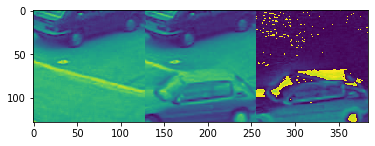

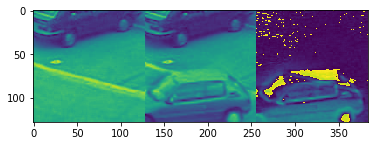

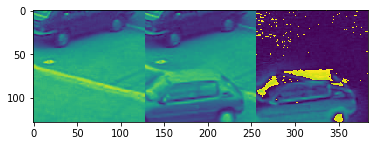

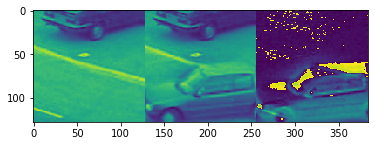

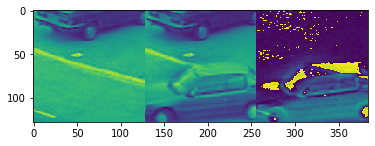

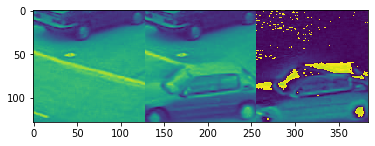

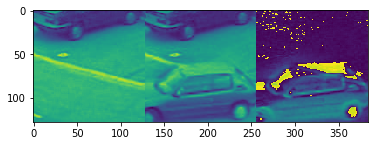

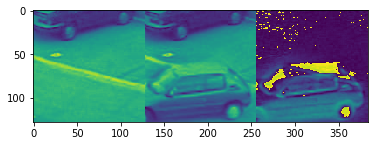

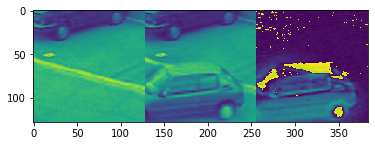

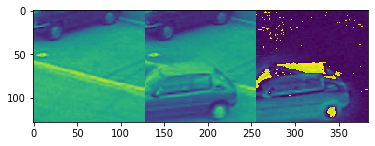

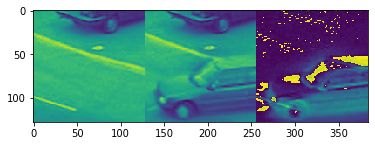

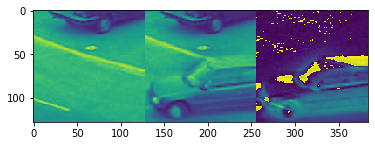

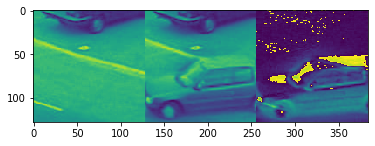

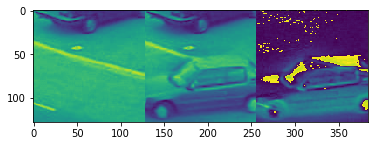

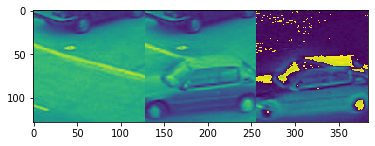

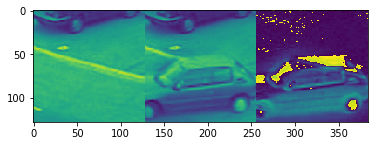

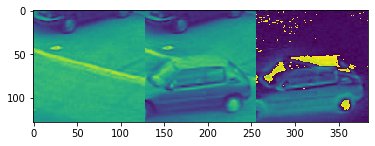

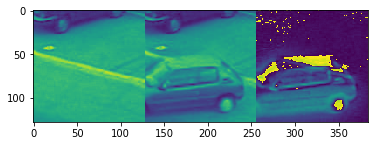

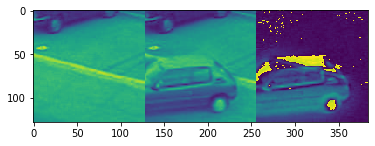

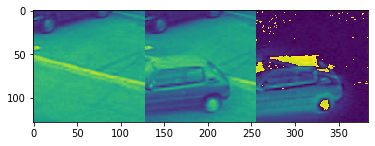

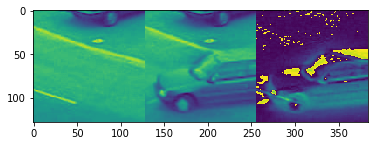

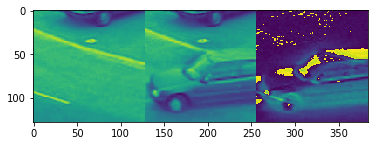

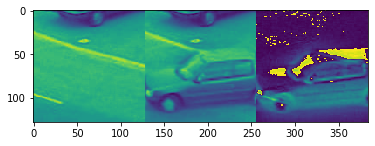

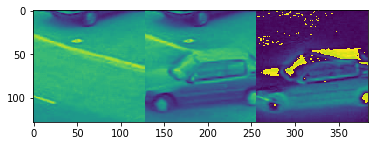

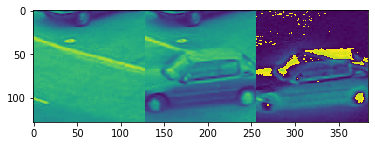

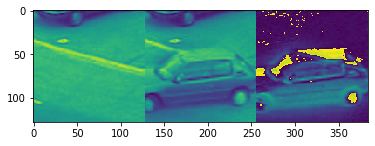

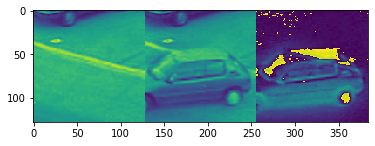

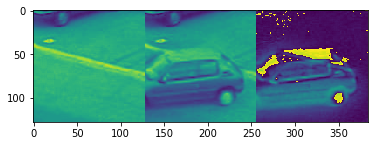

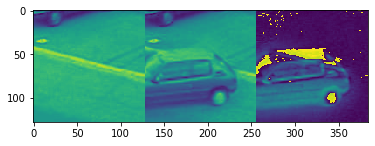

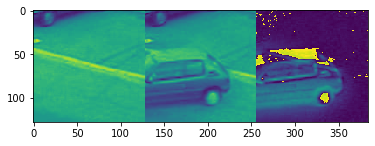

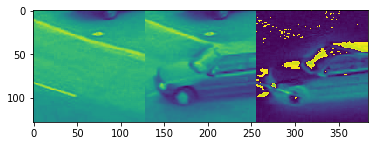

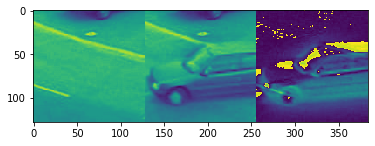

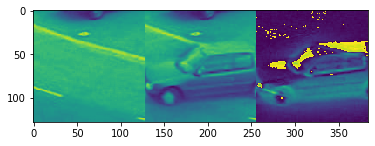

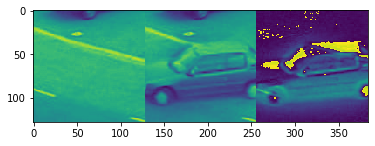

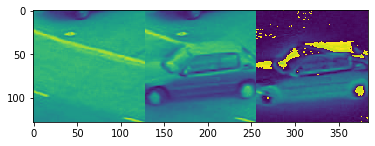

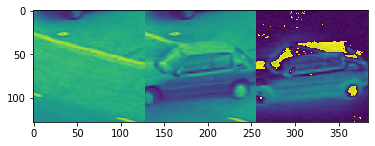

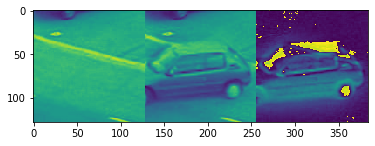

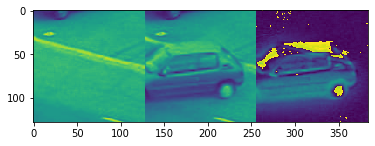

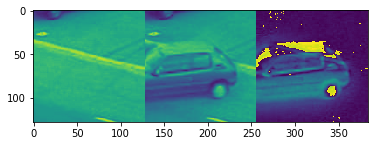

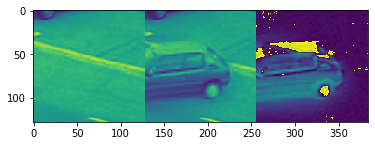

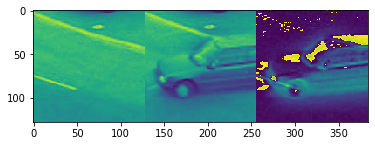

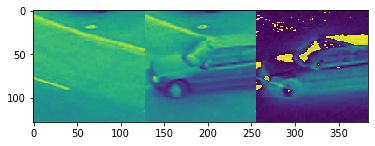

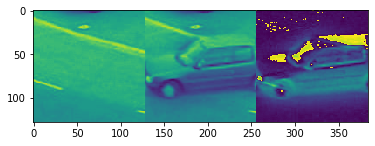

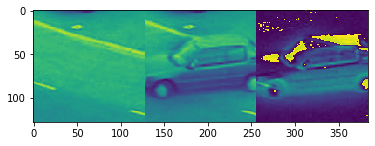

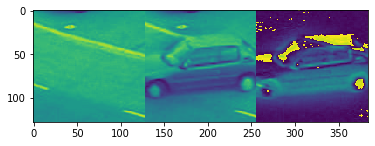

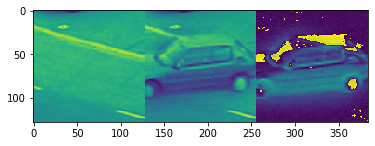

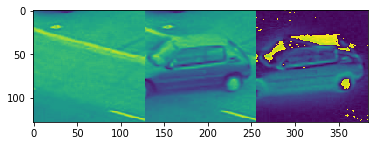

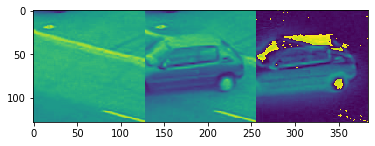

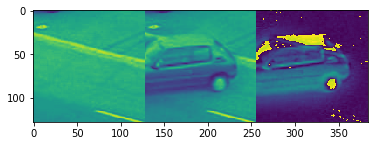

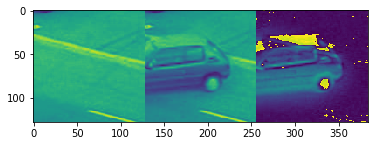

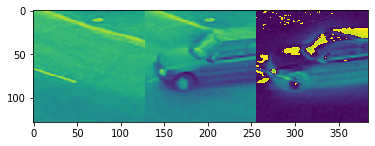

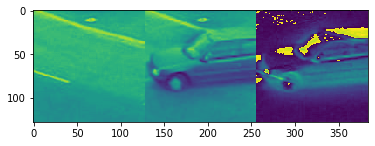

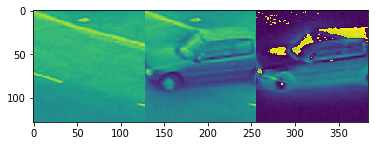

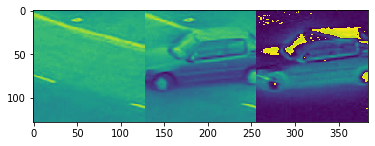

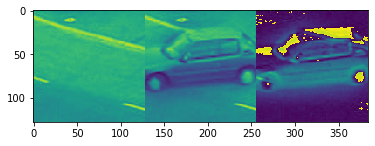

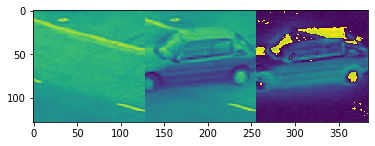

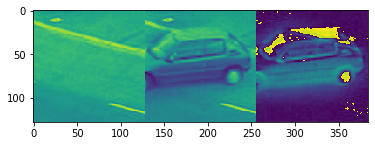

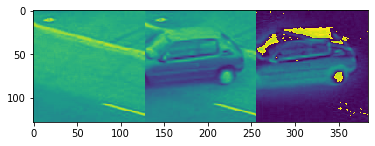

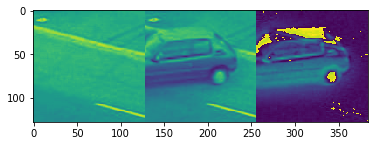

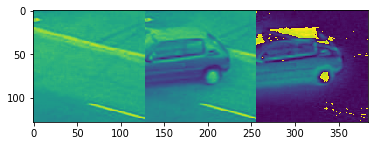

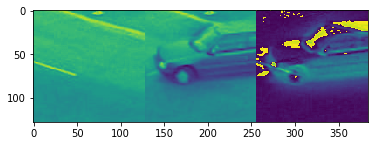

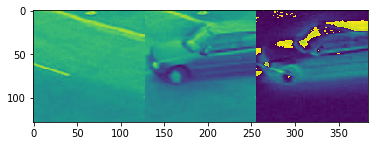

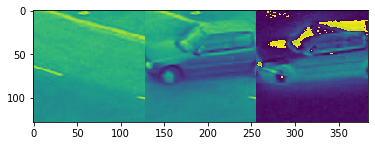

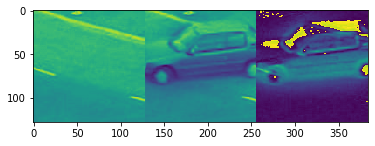

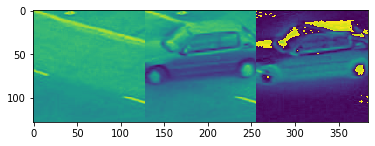

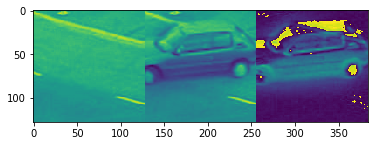

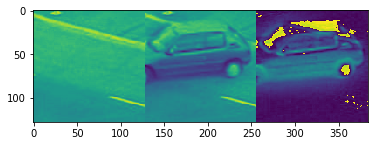

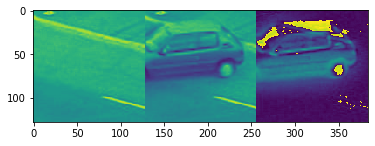

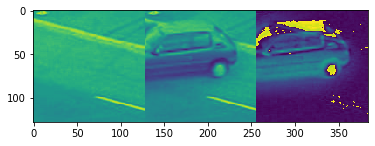

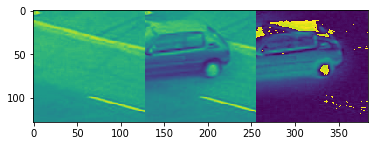

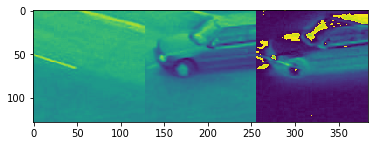

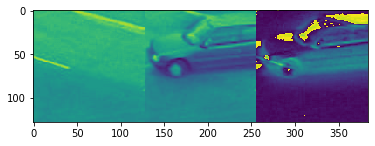

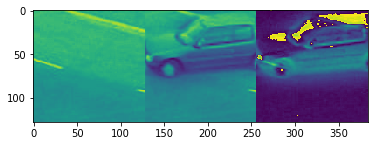

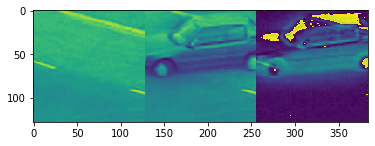

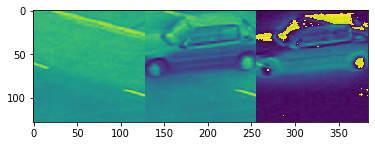

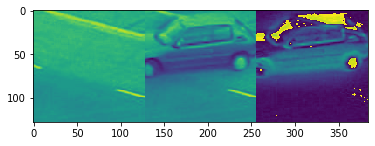

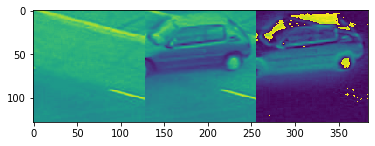

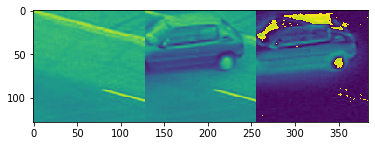

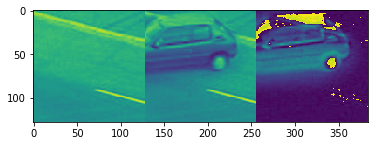

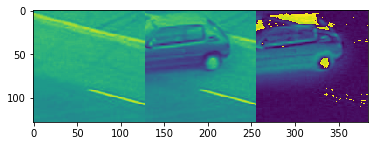

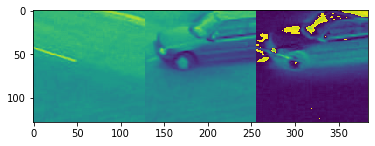

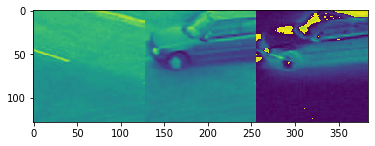

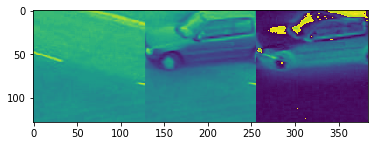

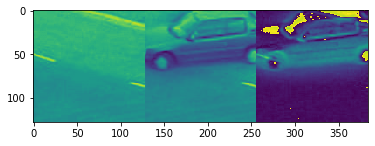

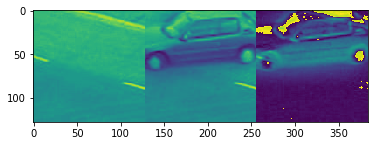

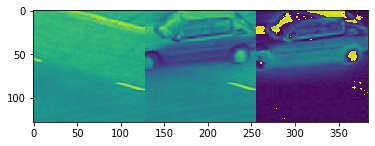

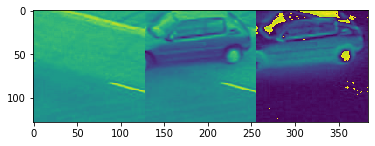

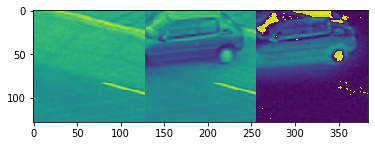

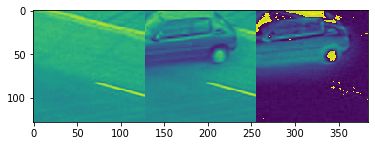

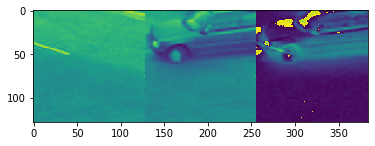

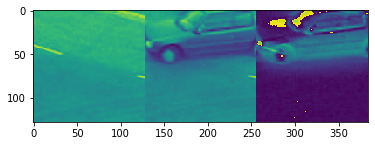

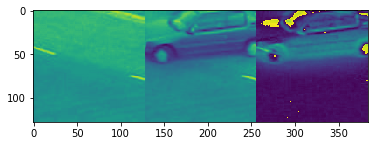

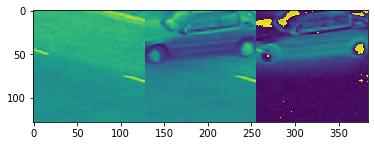

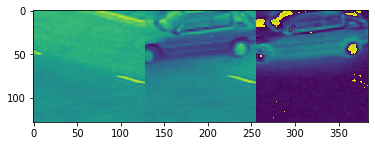

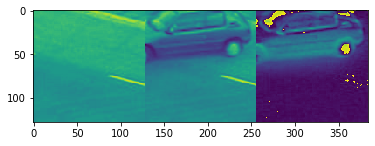

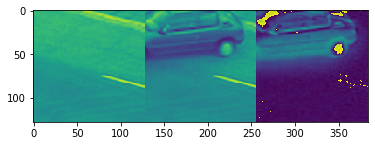

In [ ]:
for i in w:
    frame = owindows[i] - twindows[i]
    xyz= np.concatenate([owindows[i] , twindows[i],frame],axis=1)
    plt.imshow(xyz,interpolation='nearest')
    plt.show()

In [ ]:
frame = orig_frame[5]-temp_frame[5]

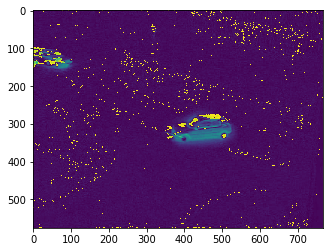

In [ ]:
plt.imshow(frame, interpolation='nearest')
plt.show()

In [ ]:
temp2_frame = frameCapture("Tempered_2.avi")
temp3_frame = frameCapture("Tempered_3.avi")

In [ ]:
t2rhist, t2chist = computeStatisticalDescriptor(temp2_frame)

mag,ang = opticalFlow(temp2_frame)
mag,ang = normalize(mag,ang)
t2ohist = computeMagAngle(mag,ang)

t2fhist = computeFinalhistogram(t2rhist,t2chist,t2ohist)

3
012

In [ ]:
import pickle
file = open('Tempered_2/rhist',"wb")
pickle.dump(t2rhist, file)
file.close()
file = open('Tempered_2/chist',"wb")
pickle.dump(t2chist, file)
file.close()
file = open('Tempered_2/ohist',"wb")
pickle.dump(t2ohist, file)
file.close()
file = open('Tempered_2/fhist',"wb")
pickle.dump(t2fhist, file)
file.close()

In [ ]:
t3rhist, t3chist = computeStatisticalDescriptor(temp3_frame)

mag,ang = opticalFlow(temp3_frame)
mag,ang = normalize(mag,ang)
t3ohist = computeMagAngle(mag,ang)

t3fhist = computeFinalhistogram(t3rhist,t3chist,t3ohist)

3
012

In [ ]:
file = open('Tempered_3/rhist',"wb")
pickle.dump(t3rhist, file)
file.close()
file = open('Tempered_3/chist',"wb")
pickle.dump(t3chist, file)
file.close()
file = open('Tempered_3/ohist',"wb")
pickle.dump(t3ohist, file)
file.close()
file = open('Tempered_3/fhist',"wb")
pickle.dump(t3fhist, file)
file.close()